<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
!pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 147.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.

In [ ]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

/tmp/ipython-input-2602539572.py:17: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


## Загрузка данных (4 балла)

In [ ]:
import pandas as pd
data = pd.read_csv('data.csv')

In [ ]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [ ]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [ ]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

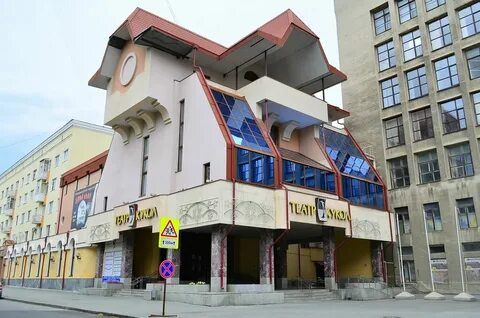

In [ ]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [ ]:
# your code here
data['description'] = data['description'].fillna('')
data['en_txt'] = data['en_txt'].fillna('')

data['full_text'] = (data['description'].astype(str) + ' ' + data['en_txt'].astype(str)).str.lower()

data['full_text'].head()

,full_text
0,спорткомплекс в екатеринбурге there are two pe...
1,спорткомплекс в екатеринбурге arafed building ...
2,спорткомплекс в екатеринбурге there is a blue ...
3,спорткомплекс в екатеринбурге there is a blue ...
4,спорткомплекс в екатеринбурге there is a boat ...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,   # чтобы не раздувать память
    min_df=5,             # слово должно встретиться хотя бы в 5 документах
    max_df=0.5,           # отсекаем слишком частые "везде встречающиеся" слова
    ngram_range=(1, 2),   # униграммы и биграммы
)

X_tfidf = vectorizer.fit_transform(data['full_text'])

In [ ]:
feature_names = np.array(vectorizer.get_feature_names_out())
idf = vectorizer.idf_

# самые частые слова (маленький idf)
top_common_idx = np.argsort(idf)[:50]
top_common_words = feature_names[top_common_idx]

# самые редкие слова (большой idf)
top_rare_idx = np.argsort(idf)[-50:]
top_rare_words = feature_names[top_rare_idx]

print("Топ частых слов:\n", ", ".join(top_common_words))
print("\nТоп редких слов:\n", ", ".join(top_rare_words))

Топ частых слов:
 building, in, and, arafed, building with, there, on, is, there is, the, екатеринбурге arafed, екатеринбурге there, front, екатеринбург, музей, of building, front of, clock, in front, it, statue, man, view, view of, with clock, памятник, памятник екатеринбурге, of man, дом, statue of, white, здание, екатеринбург arafed, large, tower, arafed view, clock tower, in the, on the, blue, top, собор екатеринбург, собор, мемориальный дом, мемориальный, and white, дом музей, храм вознесения, господня екатеринбург, вознесения

Топ редких слов:
 church and, building in, corner, chairs and, hat, has, with hat, golden dome, soldiers, stage, stadium, old, tree in, line, log cabin, window, soccer field, sitting on, and green, музей arafed, arafed wooden, скрябиной cars, arafed gazebo, of windows, of red, of men, on display, stone, tall, the foreground, of snowy, arafed photo, with gazebo, with pond, in line, is over, holding book, with golden, foreground, cloth, екатеринбурге araffatu

In [ ]:
def show_examples_for_token(token, n=5):
    mask = data['full_text'].str.contains(rf'\b{token}\b', case=False, na=False)
    examples = data[mask].sample(min(n, mask.sum()), random_state=42)
    display(examples[['Name', 'City', 'description', 'en_txt']])

In [ ]:
suspect_tokens = [
    "arafed",
    "araffature",
    "скрябиной",
    "with hat",
    "hat",
    "sitting on",
    "holding book",
    "chairs and",
    "chair and",
    "and chair",
    "cloth",
]


for tok in suspect_tokens:
    show_examples_for_token(tok)

,Name,City,description,en_txt
576,Царский мост,Екатеринбург,мост через Исеть в Екатеринбурге,arafed bridge over a river with people on it a...
238,Театр кукол,Екатеринбург,кинотеатр в Екатеринбурге,arafed image of a building with a dome and a b...
24,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,arafed view of a basketball court and a stadiu...
527,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,arafed statue of a man holding a cloth and a bag
36,Динамо,Екатеринбург,спорткомплекс в Екатеринбурге,arafed view of a city with a large dome on a s...


,Name,City,description,en_txt
53,№32 Дом обороны,Екатеринбург,здание в Екатеринбурге,araffature of a building with a plane on top o...
62,№32 Дом обороны,Екатеринбург,здание в Екатеринбурге,araffature of a building with a horse drawn ca...
371,Свято-Троицкий Кафедральный собор,Екатеринбург,Троицкий собор (Екатеринбург),araffature of a large building with a golden d...
76,Дом обороны,Екатеринбург,здание в Екатеринбурге,araffature of a building with a plane on top o...
87,Дом обороны,Екатеринбург,здание в Екатеринбурге,araffature of a building with a plane on top o...


,Name,City,description,en_txt
132,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,there is a truck parked in front of a building...
148,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,cars parked on the side of a street in front o...
131,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,arafed building with a car parked in front of it
144,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,there is a table with a book and a lamp in a room
123,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,cars parked in front of a building with a cloc...


,Name,City,description,en_txt


,Name,City,description,en_txt
455,Серго Орджоникидзе,Екатеринбург,Памятник в Екатеринбурге,arafed statue of a man with a hat and a robe
487,Серго Орджоникидзе,Екатеринбург,Памятник в Екатеринбурге,a close up of a statue of a man with a hat on
534,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,arafed statue of a man with a hat and a bag
524,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,a close up of a statue of a man with a hat on
531,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,statue of a woman with a hat and a robe on a p...


,Name,City,description,en_txt
141,№27 Дом Г.Н. Скрябина,Екатеринбург,Дом Е.Д. Скрябиной,there is a bird sitting on the sidewalk outsid...
404,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a black and white statue sitting on a...
202,Дом-музей Бажова,Екатеринбург,Мемориальный дом-музей П. П. Бажова,arafed photo of a man sitting on a rock next t...
65,№32 Дом обороны,Екатеринбург,здание в Екатеринбурге,there is a plane that is sitting on top of a b...
252,Харитоновский сад,Екатеринбург,парк в Екатеринбурге,there is a white gazebo sitting on the shore o...


,Name,City,description,en_txt


,Name,City,description,en_txt
206,Дом-музей Бажова,Екатеринбург,Мемориальный дом-музей П. П. Бажова,there is a living room with a table and chairs...
409,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a dining room with a table and chairs...
196,Дом-музей Бажова,Екатеринбург,Мемориальный дом-музей П. П. Бажова,arafed log cabin with a dining table and chair...
221,Театр кукол,Екатеринбург,кинотеатр в Екатеринбурге,arafed auditorium with rows of chairs and a st...


,Name,City,description,en_txt
417,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a desk with a chair and a cabinet in ...
405,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a chair and a table in a room with a ...


,Name,City,description,en_txt


,Name,City,description,en_txt
410,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a table with a white table cloth and ...
527,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,arafed statue of a man holding a cloth and a bag
415,Дом-музей Д. Н. Мамина-Сибиряка,Екатеринбург,Литературно-мемориальный дом-музей Д. Н. Мамин...,there is a table with a white table cloth and ...
198,Дом-музей Бажова,Екатеринбург,Мемориальный дом-музей П. П. Бажова,there is a table with a white table cloth and ...
520,Н. И. Кузнецову,Екатеринбург,Памятник в Екатеринбурге,statue of a man holding a cloth in his hands


In [ ]:
print("Число уникальных мест (Name):", clean['Name'].nunique())
print("Число уникальных городов:", clean['City'].nunique())

clean.groupby('City')['Name'].nunique().sort_values(ascending=False).head(20)


Число уникальных мест (Name): 18
Число уникальных городов: 1


,Name
City,
Екатеринбург,18


### Стратифицированная выборка по (City, Name)

In [ ]:
print("Уникальных мест (City, Name):", data[['City', 'Name']].drop_duplicates().shape[0])


Уникальных мест (City, Name): 18


In [ ]:
def stratified_sample(df, group_cols, n_per_group=3, random_state=42):
    sampled = (df.groupby(group_cols, group_keys=False)
                 .apply(lambda g: g.sample(min(len(g), n_per_group),
                                           random_state=random_state)))
    return sampled

# возьмём до 3 сэмплов на каждое (City, Name)
sampled = stratified_sample(data, ['City', 'Name'], n_per_group=3)

len(sampled), sampled.head()


/tmp/ipython-input-2431763308.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), n_per_group),


(54,
     Unnamed: 0         Name   WikiData          City        Lon        Lat  \
 24          24       Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
 13          13       Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
 8            8       Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
 95          95  Дом обороны  Q55209768  Екатеринбург  60.602409  56.835133   
 84          84  Дом обороны  Q55209768  Екатеринбург  60.602409  56.835133   
 
                       description  \
 24  спорткомплекс в Екатеринбурге   
 13  спорткомплекс в Екатеринбурге   
 8   спорткомплекс в Екатеринбурге   
 95         здание в Екатеринбурге   
 84         здание в Екатеринбурге   
 
                                                 image  \
 24  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAICAgICAQICAg...   
 13  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
 8   /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
 95  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

In [ ]:
data['desc_len'] = data['description'].fillna('').str.len()

best_rows = data.loc[
    data.groupby(['City', 'Name'])['desc_len'].idxmax()
].copy()

len(best_rows), best_rows.head()

(18,
      Unnamed: 0                              Name   WikiData          City  \
 0             0                            Динамо  Q37996725  Екатеринбург   
 68           68                       Дом обороны  Q55209768  Екатеринбург   
 178         178                  Дом-музей Бажова   Q4290214  Екатеринбург   
 397         397   Дом-музей Д. Н. Мамина-Сибиряка   Q4263805  Екатеринбург   
 151         151  Литературная жизнь Урала XX века   Q4306077  Екатеринбург   
 
            Lon        Lat                                        description  \
 0    60.600349  56.845398                      спорткомплекс в Екатеринбурге   
 68   60.602409  56.835133                             здание в Екатеринбурге   
 178  60.613415  56.818394                Мемориальный дом-музей П. П. Бажова   
 397  60.607212  56.841320  Литературно-мемориальный дом-музей Д. Н. Мамин...   
 151  60.606716  56.842705                                              Музей   
 
                               

In [ ]:
def make_doc_text(row):
    parts = [
        f"Название: {row['Name']}",
        f"Город: {row['City']}",
        str(row.get("description", "")),
        str(row.get("en_txt", "")),
    ]
    # убираем пустые куски и склеиваем
    return "\n".join(p for p in parts if p.strip())


In [ ]:
from langchain.docstore.document import Document

documents = []
for _, row in best_rows.iterrows():
    text = make_doc_text(row)

    meta = {
        "name": row["Name"],
        "city": row["City"],
        "wikidata": row["WikiData"],
        "lon": float(row["Lon"]),
        "lat": float(row["Lat"]),
        "image_b64": row["image"],
    }

    documents.append(Document(page_content=text, metadata=meta))


Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [ ]:
!pip install -q chromadb sentence-transformers ragatouille


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.9 MB/

In [ ]:
import torch
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

EMBEDDING_MODEL_NAME = "sentence-transformers/distiluse-base-multilingual-cased-v2"

device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True},  # под косинус
)

# documents — это список LangChain Document, который мы собирали раньше
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embedding_model,
    collection_name="ekb_tourism",
    persist_directory="chroma_ekb_db",
)



In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

READER_MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    device_map="auto",
    torch_dtype="auto"
)

READER_LLM = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    do_sample=False,        # отключаем "творчество"
    temperature=0.0,        # максимальная строгость
    max_new_tokens=60,      # хватит для ответа
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    return_full_text=False,
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
prompt = """
Отвечай коротко, чётко, по существу.
Не фантазируй. Не используй лишний текст.

Вопрос: Сколько будет 2+2?
Ответ:"""

raw = READER_LLM(prompt)[0]["generated_text"]
answer = raw.strip().split("\n")[0]   # только первая строка
answer



'4'

In [ ]:
from ragatouille import RAGPretrainedModel

# загрузка ColBERTv2 для rerank
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

RAG_PROMPT_TEMPLATE = """Ты — виртуальный гид по Екатеринбургу.
Используй только факты из контекста. Если в контексте нет ответа, так и скажи.

Контекст:
{context}

Вопрос:
{question}

Ответ (по-русски, кратко и по делу):
"""

def answer_with_rag(question, k_initial=15, k_final=5):
    # 1. первичный поиск по Chroma
    raw_docs = vectordb.similarity_search(question, k=k_initial)
    raw_texts = [d.page_content for d in raw_docs]

    # 2. rerank через ragatouille (ColBERTv2)
    reranked = RERANKER.rerank(question, raw_texts, k=k_final)
    top_texts = [x["content"] for x in reranked]

    # 3. собираем контекст
    context = ""
    for i, t in enumerate(top_texts):
        context += f"Документ {i+1}:\n{t}\n\n"

    prompt = RAG_PROMPT_TEMPLATE.format(context=context, question=question)

    raw = READER_LLM(prompt)[0]["generated_text"]
    answer = raw.strip().split("\n")[0]  # на всякий случай берём первую строку

    return answer, top_texts


In [ ]:
questions = [
    "Что можно рассказать туристу про Царский мост?",
    "Чем интересен Дом обороны в Екатеринбурге?",
    "Где находится памятник Серго Орджоникидзе и что он из себя представляет?",
]

for q in questions:
    ans, _ = answer_with_rag(q)
    print("Вопрос:", q)
    print("Ответ:", ans)
    print("-" * 80)


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


Вопрос: Что можно рассказать туристу про Царский мост?
Ответ: Царский мост в Екатеринбурге — это мост через реку Исеть с видом на здание и достопримечательность. На фото виден красный дом с зеленым крышей и белой дверью, а также
--------------------------------------------------------------------------------
WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results


100%|██████████| 1/1 [00:00<00:00, 27.28it/s]


Вопрос: Чем интересен Дом обороны в Екатеринбурге?
Ответ: Дом обороны в Екатеринбурге не упоминается в предоставленных документах. Отсутствуют сведения о его архитектуре, внешнем виде или интересных особенностях. 
--------------------------------------------------------------------------------
WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results


100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


Вопрос: Где находится памятник Серго Орджоникидзе и что он из себя представляет?
Ответ: В Екатеринбурге нет памятника Серго Орджоникидзе. В документах упоминается только один памятник в Екатеринбурге - архангельский храм Вознесения Господня с
--------------------------------------------------------------------------------


In [ ]:
route_question = """
Составь пеший маршрут по Екатеринбургу на 1 день из 4–5 мест из датасета.
Кратко опиши каждую точку и порядок посещения.
"""
answer, _ = answer_with_rag(route_question)
print(answer)


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results


100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Маршрут: Исетьский мост → Успенский собор → Храм Вознесения Господня → Троицкий собор.


Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [ ]:
# your code here
texts = [doc.page_content for doc in documents]
embeddings = embedding_model.embed_documents(texts)

import numpy as np
X = np.array(embeddings)
X.shape


(18, 512)

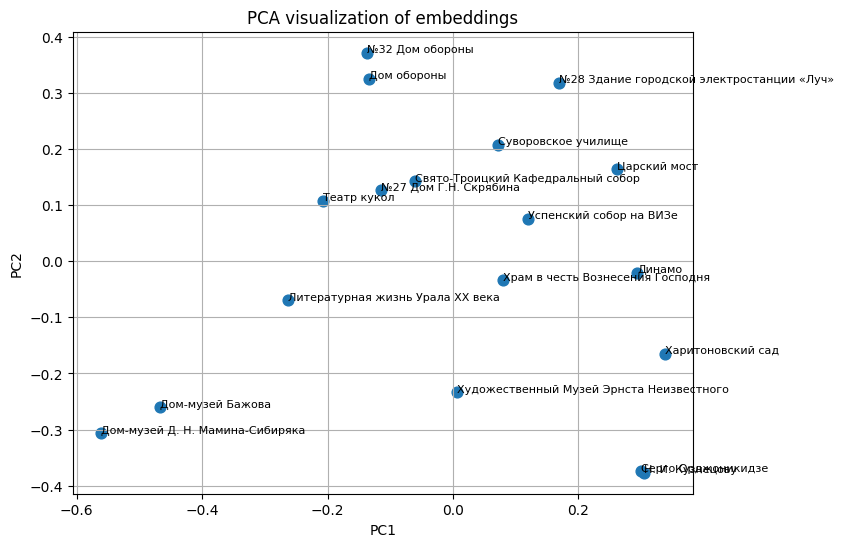

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=60)

for i, doc in enumerate(documents):
    name = doc.metadata.get("name", "")
    plt.text(X_pca[i, 0], X_pca[i, 1], name, fontsize=8)

plt.title("PCA visualization of embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [ ]:
!pip install umap-learn


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


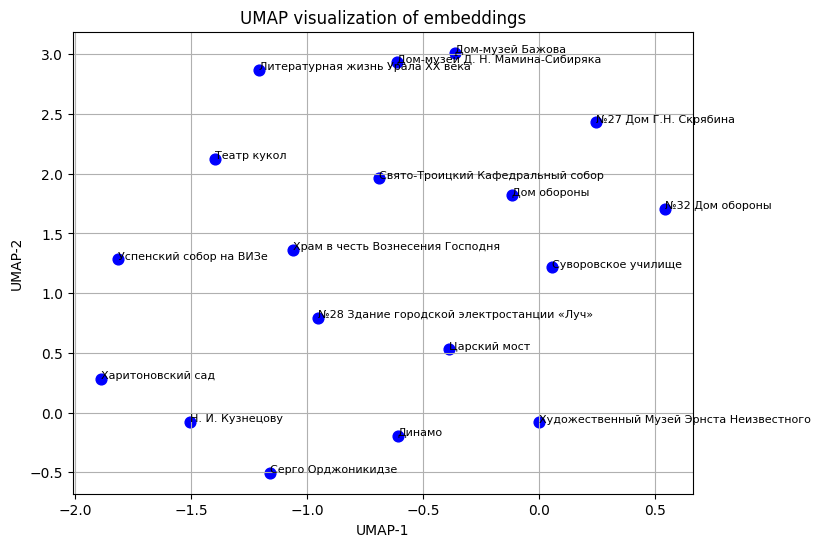

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=60, c="blue")

for i, doc in enumerate(documents):
    name = doc.metadata.get("name", "")
    plt.text(X_umap[i, 0], X_umap[i, 1], name, fontsize=8)

plt.title("UMAP visualization of embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

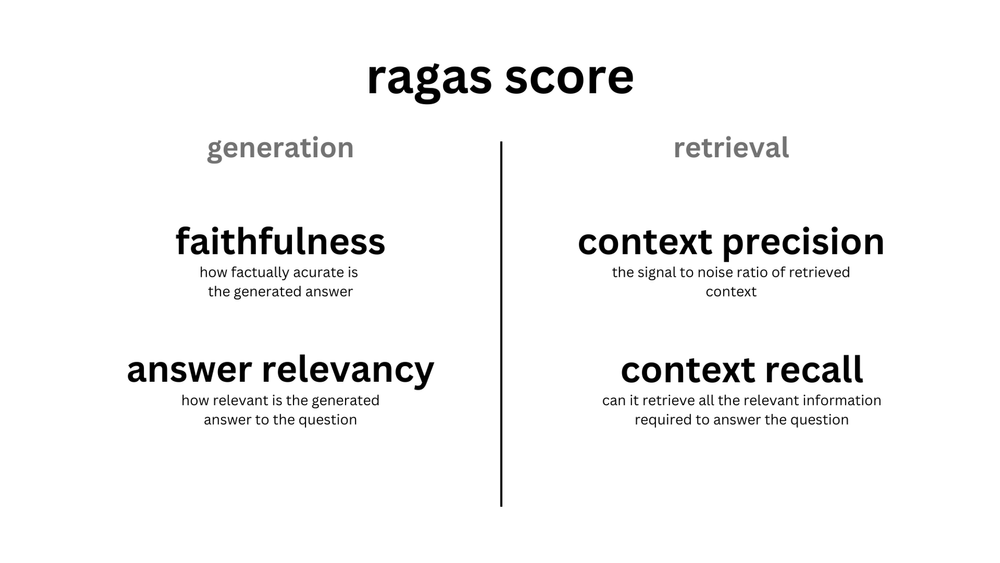

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

def data_preprocess(
    data: pd.DataFrame,
    rag_fn,
    n_samples: int = 100,
    random_state: int = 42,
):
    """
    data      — исходный датафрейм с колонками как минимум Name, City, description
    rag_fn    — функция, которая по вопросу возвращает (answer, contexts)
    n_samples — сколько примеров взять для оценки RAG

    Возвращает датафрейм с колонками:
    question, ground_truths, answer, contexts
    """
    # берём случайные уникальные места (если их меньше 100 — сколько есть)
    sampled = data.sample(
        min(n_samples, len(data)),
        random_state=random_state
    )

    rows = []
    for _, row in tqdm(sampled.iterrows(), total=len(sampled)):
        # можно придумать любой шаблон вопроса — главное, чтобы он был осмысленным
        question = f"Расскажи туристу про достопримечательность «{row['Name']}» в городе {row['City']}."

        # ответ RAG (answer_with_rag)
        answer, used_contexts = rag_fn(question)

        # ground_truth можно взять как исходное описание из датасета
        gt = make_doc_text(row)

        # contexts — список строк (тексты документов, из которых RAG отвечал)
        # если rag_fn возвращает объекты Document, вытаскиваем .page_content
        contexts = []
        for c in used_contexts:
            if hasattr(c, "page_content"):
                contexts.append(c.page_content)
            else:
                contexts.append(str(c))

        rows.append({
            "question": question,
            "ground_truths": [gt],   # RAGAS ожидает лист строк
            "answer": answer,
            "contexts": contexts,    # тоже лист строк
        })

    eval_df = pd.DataFrame(rows)
    return eval_df


eval_df = data_preprocess(data, answer_with_rag, n_samples=100)
eval_df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 27.15it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.94it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.73it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.61it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.00it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 53.78it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.59it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.91it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.67it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.84it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.88it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.11it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.83it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 47.54it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.98it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.47it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 53.93it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 36.65it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.95it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.84it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.73it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 48.96it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.53it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.41it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.04it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.71it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.99it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.61it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.03it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.50it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.75it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.65it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.32it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.98it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.04it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.16it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.18it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.56it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.94it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 39.52it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 54.80it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.48it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.52it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.55it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.91it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 51.50it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 55.74it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.81it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.87it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 50.29it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 42.38it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.09it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.22it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.98it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.17it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.81it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.30it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.26it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 51.92it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 50.81it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 35.50it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.61it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 42.23it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.49it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.79it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 37.80it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.84it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.21it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.85it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 53.58it/s]


,question,ground_truths,answer,contexts
0,Расскажи туристу про достопримечательность «№2...,[Название: №28 Здание городской электростанции...,В Екатеринбурге находится уникальная достоприм...,[Название: №28 Здание городской электростанции...
1,Расскажи туристу про достопримечательность «Хр...,[Название: Храм в честь Вознесения Господня\nГ...,Храм в честь Вознесения Господня находится в Е...,[Название: Храм в честь Вознесения Господня\nГ...
2,Расскажи туристу про достопримечательность «Ус...,[Название: Успенский собор на ВИЗе\nГород: Ека...,"Извините, но в предоставленных документах нет ...",[Название: №28 Здание городской электростанции...
3,Расскажи туристу про достопримечательность «До...,[Название: Дом обороны\nГород: Екатеринбург\nз...,"Извините, но в предоставленных документах нет ...",[Название: Художественный Музей Эрнста Неизвес...
4,Расскажи туристу про достопримечательность «До...,[Название: Дом-музей Бажова\nГород: Екатеринбу...,Дом-музей Павла Петровича Бажова находится в Е...,[Название: Художественный Музей Эрнста Неизвес...


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer

def answer_relevancy(
    eval_df: pd.DataFrame,
    model_name: str = "sentence-transformers/distiluse-base-multilingual-cased-v2",
    batch_size: int = 32,
    return_per_sample: bool = False,
):
    """
    eval_df — датафрейм с колонками 'question' и 'answer'
    model_name — эмбеддер для вычисления косинусного сходства
    return_per_sample — если True, вернуть массив со значением для каждого примера

    Возвращает:
      - средний скор по всем примерам (float)
      - и, опционально, массив per-sample значений
    """
    model = SentenceTransformer(model_name)

    questions = eval_df["question"].tolist()
    answers = eval_df["answer"].tolist()

    # считаем эмбеддинги и нормализуем — тогда косинус = скалярное произведение
    q_emb = model.encode(
        questions,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    a_emb = model.encode(
        answers,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )

    # косинусное сходство для каждой пары
    sims = (q_emb * a_emb).sum(axis=1)  # потому что уже нормализованы

    mean_score = float(sims.mean())

    if return_per_sample:
        return mean_score, sims
    else:
        return mean_score


mean_ar, per_sample = answer_relevancy(eval_df, return_per_sample=True)
print("Средний answer_relevancy:", mean_ar)


Средний answer_relevancy: 0.6156127452850342


# Протестируйте ваш RAG (3 балла)

In [ ]:
# берём 100 примеров (или меньше, если данных мало)
eval_df = data_preprocess(
    data=data,
    rag_fn=answer_with_rag,
    n_samples=100,
    random_state=42,
)

eval_df.head()


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.45it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 68.11it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.51it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.51it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.42it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.96it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.98it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.74it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.30it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.71it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 65.75it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.34it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 65.18it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 68.18it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.68it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.91it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.60it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 65.01it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.39it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.13it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.37it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.49it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.67it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.22it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.55it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.06it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.12it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.85it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.85it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.95it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.94it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.16it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.76it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.40it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.93it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.51it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.38it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 68.46it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.08it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 71.60it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.12it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 53.52it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.32it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.30it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.91it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.72it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 55.86it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 35.09it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 68.25it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.64it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 44.24it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.92it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.08it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.67it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.17it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.08it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.05it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.10it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.28it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 54.33it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 71.46it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 43.80it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.85it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.39it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 63.84it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 60.88it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 64.11it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.33it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 66.25it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.56it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 73.95it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.44it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 51.01it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.43it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.45it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 56.78it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 62.59it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 29.30it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 52.38it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 70.39it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 40.15it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.72it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 61.22it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 56.51it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 55.11it/s]


WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results



100%|██████████| 1/1 [00:00<00:00, 67.55it/s]


,question,ground_truths,answer,contexts
0,Расскажи туристу про достопримечательность «№2...,[здание и достопримечательность в Екатеринбурге],Достопримечательностью №28 в Екатеринбурге явл...,[здание и достопримечательность в Екатеринбург...
1,Расскажи туристу про достопримечательность «Хр...,[Храм Вознесения Господня (Екатеринбург)],Храм Вознесения Господня в Екатеринбурге имеет...,[здание и достопримечательность в Екатеринбург...
2,Расскажи туристу про достопримечательность «Ус...,[Успенский собор (Екатеринбург)],Успенский собор на ВИЗе — это архитектурный па...,[здание и достопримечательность в Екатеринбург...
3,Расскажи туристу про достопримечательность «До...,[здание в Екатеринбурге],"Извините, но среди предоставленных документов ...",[здание и достопримечательность в Екатеринбург...
4,Расскажи туристу про достопримечательность «До...,[Мемориальный дом-музей П. П. Бажова],"Извините, но в предоставленных документах нет ...",[здание и достопримечательность в Екатеринбург...


In [ ]:
mean_ar, sims = answer_relevancy(eval_df, return_per_sample=True)

print("Средний answer_relevancy на выборке:", round(mean_ar, 3))

eval_df["answer_relevancy"] = sims
eval_df["gt"] = eval_df["ground_truths"].str[0]


Средний answer_relevancy на выборке: 0.616


In [ ]:
eval_df.sort_values("answer_relevancy", ascending=False)[
    ["question", "answer", "gt", "answer_relevancy"]
].head(5)


,question,answer,gt,answer_relevancy
35,Расскажи туристу про достопримечательность «Ху...,Художественный музей Эрнста Неизвестного наход...,Название: Художественный Музей Эрнста Неизвест...,0.746083
29,Расскажи туристу про достопримечательность «Ху...,Художественный музей Эрнста Неизвестного наход...,Название: Художественный Музей Эрнста Неизвест...,0.746083
80,Расскажи туристу про достопримечательность «Ху...,Художественный музей Эрнста Неизвестного наход...,Название: Художественный Музей Эрнста Неизвест...,0.746083
38,Расскажи туристу про достопримечательность «Ху...,Художественный музей Эрнста Неизвестного наход...,Название: Художественный Музей Эрнста Неизвест...,0.746083
74,Расскажи туристу про достопримечательность «Ху...,Художественный музей Эрнста Неизвестного наход...,Название: Художественный Музей Эрнста Неизвест...,0.746083


In [ ]:
eval_df.sort_values("answer_relevancy")[
    ["question", "answer", "gt", "answer_relevancy"]
].head(5)


,question,answer,gt,answer_relevancy
2,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),0.335587
28,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),0.335587
43,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),0.335587
42,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),0.335587
49,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),0.335587


In [ ]:
eval_df.sample(3, random_state=0)[
    ["question", "answer", "gt", "contexts", "answer_relevancy"]
]


,question,answer,gt,contexts,answer_relevancy
26,Расскажи туристу про достопримечательность «До...,"Извините, но среди предоставленных документов ...",здание в Екатеринбурге,[здание и достопримечательность в Екатеринбург...,0.576260
86,Расскажи туристу про достопримечательность «Ли...,"Достопримечательность ""Литературно-мемориальны...",Музей,[здание и достопримечательность в Екатеринбург...,0.385352
2,Расскажи туристу про достопримечательность «Ус...,Успенский собор на ВИЗе — это архитектурный па...,Успенский собор (Екатеринбург),[здание и достопримечательность в Екатеринбург...,0.335587


# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# Вспомогательное — разбиение ответа на «утверждения»
import re

def split_into_claims(text: str):
    text = text.strip()
    if not text:
        return []
    # простое разбиение по . ! ? + перевод строки
    sents = re.split(r'(?<=[\.\!\?])\s+', text)
    # убираем пустые куски
    sents = [s.strip() for s in sents if s.strip()]
    return sents


In [ ]:
# Faithfulness (через эмбеддинги)

import numpy as np
from sentence_transformers import SentenceTransformer

def faithfulness(
    eval_df,
    model_name: str = "sentence-transformers/distiluse-base-multilingual-cased-v2",
    batch_size: int = 32,
    threshold: float = 0.6,
    return_per_sample: bool = False,
):
    """
    eval_df: должен содержать колонки 'answer' и 'contexts'
      - answer: строка
      - contexts: список строк

    threshold: порог косинусного сходства, начиная с которого считаем,
               что утверждение поддержано контекстом.
    """
    model = SentenceTransformer(model_name)

    scores = []

    for _, row in eval_df.iterrows():
        answer = row["answer"]
        contexts = row["contexts"]

        claims = split_into_claims(answer)
        if not claims:
            # если модель вообще ничего не сказала — считаем пример тривиально честным
            scores.append(1.0)
            continue

        # объединяем claims + contexts, чтобы за один encode получить эмбеддинги
        texts = claims + contexts
        embs = model.encode(
            texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            normalize_embeddings=True,
        )

        claim_embs = embs[: len(claims)]
        ctx_embs = embs[len(claims) :]

        # матрица косинусных сходств (так как нормализовано → скалярное произведение)
        sim_matrix = claim_embs @ ctx_embs.T  # shape: [num_claims, num_ctx]

        # макс. сходство каждого утверждения с каким-либо контекстом
        max_sims = sim_matrix.max(axis=1)

        supported = (max_sims >= threshold).sum()
        score = supported / len(claims)
        scores.append(score)

    scores = np.array(scores, dtype=float)
    mean_score = float(scores.mean()) if len(scores) > 0 else 0.0

    if return_per_sample:
        return mean_score, scores
    else:
        return mean_score


In [ ]:
# пример

faith_mean, faith_per_sample = faithfulness(eval_df, return_per_sample=True)
print("Средний Faithfulness:", round(faith_mean, 3))
eval_df["faithfulness"] = faith_per_sample

Средний Faithfulness: 0.14


In [ ]:
def retrieval_recall(
    eval_df,
    model_name: str = "sentence-transformers/distiluse-base-multilingual-cased-v2",
    batch_size: int = 32,
    threshold: float = 0.6,
    return_per_sample: bool = False,
):
    """
    Оценка качества ретривера:
    для каждого вопроса смотрим, попал ли хотя бы один контекст,
    семантически похожий на ground_truth.

    eval_df: колонки 'ground_truths' (список строк) и 'contexts' (список строк)
    """
    model = SentenceTransformer(model_name)

    scores = []

    for _, row in eval_df.iterrows():
        gts = row["ground_truths"]
        if isinstance(gts, list) and len(gts) > 0:
            gt = gts[0]
        else:
            gt = str(gts)

        contexts = row["contexts"]
        if not contexts:
            scores.append(0.0)
            continue

        texts = [gt] + contexts
        embs = model.encode(
            texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            normalize_embeddings=True,
        )

        gt_emb = embs[0:1]        # shape (1, D)
        ctx_embs = embs[1:]       # shape (num_ctx, D)

        sims = (gt_emb @ ctx_embs.T).flatten()
        max_sim = float(sims.max())

        hit = 1.0 if max_sim >= threshold else 0.0
        scores.append(hit)

    scores = np.array(scores, dtype=float)
    mean_score = float(scores.mean()) if len(scores) > 0 else 0.0

    if return_per_sample:
        return mean_score, scores
    else:
        return mean_score


In [ ]:
retr_mean, retr_hits = retrieval_recall(eval_df, return_per_sample=True)
print("Retrieval recall (доля примеров, где нашлась релевантная контекстная дока):",
      round(retr_mean, 3))

eval_df["retrieval_hit"] = retr_hits

Retrieval recall (доля примеров, где нашлась релевантная контекстная дока): 0.89


**Faithfulness**:
Для каждого ответа модель разбивается на предложения, считается, насколько каждое поддержано контекстом (по косинусному сходству эмбеддингов).

*Средний Faithfulness* = 0.14

Почему: во-первых, как я думаю, из-за коротких предложений, то есть модель отвечает правильно, но из-за несовпадения с контектом - это галлюцинации

**Retrieval recall**:
Для каждого вопроса смотрим, нашёл ли retriever хотя бы один документ, похожий на ground-truth описание.

*Средний recall* = 0.89

Почему: данные содержат малосодержательные BLIP-caption, которые плохо согласуются с ground truth описаниями